# **Network Intrusion Detection System Prototype**
This notebook implements a complete NIDS using advanced ensemble models

**Author's**
-   **Wasif Nawaz**
-   **Samar Asad**

**Group ID:** F24PROJECTCE3A6 (BC210424643,BC210401276)

---

##  **Warning:**
- Please proceede step by step to avoid any errors.
- Use runtime as **T4**  

In [1]:
# Install necessary libraries
!pip uninstall -y numpy pandas scikit-learn xgboost lightgbm catboost pytorch-tabnet
!pip install -q numpy --upgrade --force-reinstall --no-cache-dir
!pip install -q pandas scikit-learn xgboost lightgbm catboost pytorch-tabnet

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
Found existing installation: lightgbm 4.5.0
Uninstalling lightgbm-4.5.0:
  Successfully uninstalled lightgbm-4.5.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 121.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 3.6.3 requires pandas>=1.2, which is not installed.
cudf-cu12 25.2.1 requires pandas<2.2.

In [ ]:
# Please make sure to restart the session to avoide conflicts
import os
os._exit(00)

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
# -------------------------------
# Data Upload and Processing
# -------------------------------

# Function to upload Wireshark CSV data
from google.colab import files

def upload_wireshark_data():
    """
    Upload Wireshark data exported as CSV.
    """
    print("Please upload your Wireshark capture exported as CSV.")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Uploaded {filename} ({len(uploaded[filename])} bytes)")
        os.makedirs('data', exist_ok=True)
        with open(f'data/{filename}', 'wb') as f:
            f.write(uploaded[filename])
        return f'data/{filename}'
    return None

# Function to process and extract features from Wireshark CSV data
def process_wireshark_data(file_path, sample_test_data=False):
    """
    Process Wireshark CSV data and extract relevant features.

    Parameters:
    - file_path: Path to the Wireshark CSV file.
    - sample_test_data: Not used here (CSV-only mode).

    Returns:
    - Processed DataFrame with features.
    """
    print("Reading and processing Wireshark data...")
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    print(f"Original DataFrame shape: {df.shape}")
    print("Column names:", df.columns.tolist())

    try:
        # Process time features
        if 'Time' in df.columns:
            try:
                df['Timestamp'] = pd.to_datetime(df['Time'])
                df['Hour'] = df['Timestamp'].dt.hour
                df['Minute'] = df['Timestamp'].dt.minute
                df['Second'] = df['Timestamp'].dt.second
            except:
                df['Timestamp'] = df['Time']

        # Process IP addresses
        if 'Source' in df.columns and 'Destination' in df.columns:
            df['Source_IP'] = df['Source'].apply(lambda x: extract_ip(x))
            df['Dest_IP'] = df['Destination'].apply(lambda x: extract_ip(x))
            df['Source_Internal'] = df['Source_IP'].apply(lambda x: is_internal_ip(x))
            df['Dest_Internal'] = df['Dest_IP'].apply(lambda x: is_internal_ip(x))

        # Process packet length
        if 'Length' in df.columns:
            df['Length'] = pd.to_numeric(df['Length'], errors='coerce')
            df['Length'].fillna(0, inplace=True)

        # Process additional features from Info column
        if 'Info' in df.columns:
            df['TCP_Flags'] = df.apply(lambda row: extract_tcp_flags(row), axis=1)
            df['Source_Port'] = df.apply(lambda row: extract_source_port(row), axis=1)
            df['Dest_Port'] = df.apply(lambda row: extract_dest_port(row), axis=1)

        # Calculate time differences between packets
        df = df.sort_values('Time')
        df['Time_Delta'] = df['Time'].diff().fillna(0)

        # Packet rate features
        window_sizes = [10, 50, 100]
        for size in window_sizes:
            df[f'Packet_Rate_{size}'] = df['Length'].rolling(window=size).mean().fillna(0)

        # Create a placeholder label (0 for normal)
        df['Label'] = 0

        # For demonstration, flag high packet rates and rare protocols as malicious
        df.loc[df['Packet_Rate_100'] > df['Packet_Rate_100'].quantile(0.95), 'Label'] = 1
        protocol_counts = df['Protocol'].value_counts()
        rare_protocols = protocol_counts[protocol_counts < protocol_counts.quantile(0.10)].index
        df.loc[df['Protocol'].isin(rare_protocols), 'Label'] = 1

        features = create_final_feature_set(df)
        print(f"Processed DataFrame shape: {features.shape}")
        print(f"Number of features: {features.shape[1]}")
        return features
    except Exception as e:
        print(f"Error during processing: {e}")
        import traceback
        traceback.print_exc()
        return None

# Helper functions for feature extraction
def extract_ip(ip_string):
    try:
        if isinstance(ip_string, str):
            ip_parts = ip_string.split(':')
            return ip_parts[0]
        return str(ip_string)
    except:
        return str(ip_string)

def is_internal_ip(ip):
    try:
        if not isinstance(ip, str):
            return False
        if ip.startswith('10.') or ip.startswith('192.168.') or ip.startswith('172.'):
            return True
        return False
    except:
        return False

def extract_tcp_flags(row):
    try:
        if row['Protocol'] == 'TCP' and isinstance(row['Info'], str):
            flags = []
            info = row['Info'].lower()
            if 'syn' in info:
                flags.append('SYN')
            if 'ack' in info:
                flags.append('ACK')
            if 'fin' in info:
                flags.append('FIN')
            if 'rst' in info:
                flags.append('RST')
            if 'psh' in info:
                flags.append('PSH')
            if 'urg' in info:
                flags.append('URG')
            return ','.join(flags)
        return ''
    except:
        return ''

def extract_source_port(row):
    """
    Extract the source port.
    First, it checks if the 'Source' field contains a port (formatted as "IP:port").
    If not, it attempts to parse the 'Info' field which is expected to have a format like:
    "443  >  55741 Len=25" (extracting 443 as the source port).
    """
    try:
        # Check if 'Source' contains a colon (indicating "IP:port")
        if isinstance(row['Source'], str) and ':' in row['Source']:
            parts = row['Source'].split(':')
            if len(parts) > 1 and parts[1].strip().isdigit():
                return int(parts[1].strip())
        # Fallback: try to extract from the 'Info' field
        if isinstance(row['Info'], str):
            # Split on '>' to separate source and destination parts.
            parts = row['Info'].split('>')
            if len(parts) >= 1:
                src_info = parts[0].strip()  # e.g., "443"
                # Sometimes there might be extra tokens, so pick the last numeric token
                tokens = src_info.split()
                for token in reversed(tokens):
                    if token.isdigit():
                        return int(token)
        return 0
    except Exception as e:
        return 0

def extract_dest_port(row):
    """
    Extract the destination port.
    First, it checks if the 'Destination' field contains a port (formatted as "IP:port").
    If not, it attempts to parse the 'Info' field (expecting a format like "443  >  55741 Len=25")
    to extract 55741 as the destination port.
    """
    try:
        if isinstance(row['Destination'], str) and ':' in row['Destination']:
            parts = row['Destination'].split(':')
            if len(parts) > 1 and parts[1].strip().isdigit():
                return int(parts[1].strip())
        if isinstance(row['Info'], str):
            parts = row['Info'].split('>')
            if len(parts) >= 2:
                dest_info = parts[1].strip()  # e.g., "55741 Len=25"
                tokens = dest_info.split()
                if tokens and tokens[0].isdigit():
                    return int(tokens[0])
        return 0
    except Exception as e:
        return 0

def create_final_feature_set(df):
    feature_cols = [col for col in df.columns if col not in ['No.', 'Time', 'Source', 'Destination', 'Info', 'Timestamp']]
    features = df[feature_cols].copy()
    cat_features = ['Protocol', 'TCP_Flags', 'Source_IP', 'Dest_IP']
    cat_features = [f for f in cat_features if f in features.columns]
    for feature in cat_features:
        le = LabelEncoder()
        features[feature] = le.fit_transform(features[feature].astype(str))
    features.fillna(0, inplace=True)
    return features

In [3]:
# -------------------------------
# Data Preprocessing and Modeling
# -------------------------------

def preprocess_data(df):
    """
    Preprocess data for ML modeling (separates features and label and scales numerical features).

    Returns:
    - X: Preprocessed feature matrix.
    - y: Target labels.
    - feature_names: List of feature names.
    - scaler: Fitted StandardScaler.
    """
    if df is None:
        return None, None, None, None
    print("Preprocessing data for modeling...")
    X = df.drop('Label', axis=1)
    y = df['Label']
    feature_names = X.columns.tolist()
    num_features = X.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    X[num_features] = scaler.fit_transform(X[num_features])
    print(f"Data preprocessed: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Class distribution: {np.bincount(y)}")
    return X, y, feature_names, scaler

def train_tabnet(X_train, y_train, X_val, y_val):
    print("Training TabNet model...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    model = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size": 10, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        device_name=device
    )
    X_train_np = X_train.values.astype(np.float32)
    y_train_np = y_train.values.astype(np.int64)
    X_val_np = X_val.values.astype(np.float32)
    y_val_np = y_val.values.astype(np.int64)
    model.fit(
        X_train=X_train_np, y_train=y_train_np,
        eval_set=[(X_val_np, y_val_np)],
        max_epochs=50,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        eval_metric=['auc']
    )
    return model

def train_catboost(X_train, y_train):
    print("Training CatBoost model...")
    model = cb.CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=100
    )
    model.fit(X_train, y_train)
    return model

def train_lightgbm(X_train, y_train):
    print("Training LightGBM model...")
    model = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    print("Training XGBoost model...")
    model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

def train_stacking_ensemble(X_train, y_train):
    print("Training Stacking Ensemble model...")
    estimators = [
        ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)),
        ('cat', cb.CatBoostClassifier(iterations=100, learning_rate=0.05, depth=4, verbose=0, random_seed=42))
    ]
    model = StackingClassifier(
        estimators=estimators,
        final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
        cv=5,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test, model_name, feature_names, threshold=0.5):
    """
    Evaluate the model performance, generate and display confusion matrix and feature importance plots,
    and print the classification report.
    """
    print(f"\nEvaluating {model_name}...")

    if model_name == 'TabNet':
        X_test_np = X_test.values.astype(np.float32)
        y_pred_proba = model.predict_proba(X_test_np)
        y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    else:
        y_pred_proba = model.predict_proba(X_test)
        y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_pred_proba[:, 1])

    # Print metrics
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc_val:.4f}")

    # Create and display confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    # Ensure results directory exists
    os.makedirs('results', exist_ok=True)
    plt.savefig(f'results/confusion_matrix_{model_name}.png')
    plt.show()  # Display inline
    plt.close()

    # Create and display feature importance plot if applicable
    if feature_names is not None and model_name in ['XGBoost', 'LightGBM', 'CatBoost', 'StackingEnsemble']:
        try:
            if model_name == 'XGBoost':
                importances = model.feature_importances_
            elif model_name == 'LightGBM':
                importances = model.feature_importances_
            elif model_name == 'CatBoost':
                importances = model.get_feature_importance()
            else:  # For Stacking Ensemble, use one of the base models
                importances = model.estimators_[0].feature_importances_

            plt.figure(figsize=(10, 8))
            indices = np.argsort(importances)[::-1]
            plt.title(f'Feature Importance - {model_name}')
            plt.barh(range(min(15, len(indices))), importances[indices[:15]], align='center')
            plt.yticks(range(min(15, len(indices))), [feature_names[i] for i in indices[:15]])
            plt.xlabel('Importance')
            plt.tight_layout()
            os.makedirs('results', exist_ok=True)
            plt.savefig(f'results/feature_importance_{model_name}.png')
            plt.show()  # Display inline
            plt.close()
        except Exception as e:
            print(f"Could not generate feature importance for {model_name}: {e}")

    # Print classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    # Return the performance metrics in a dictionary
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc_val,
        'confusion_matrix': cm,
        'threshold': threshold
    }

    return results


def visualize_results(all_results):
    """
    Create, save, and display a bar chart comparing model performance metrics.
    Also prints a textual summary of all metrics.
    """
    print("Creating combined model performance visualization...")
    os.makedirs('results', exist_ok=True)
    models = [result['model_name'] for result in all_results]
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']

    plt.figure(figsize=(12, 6))
    x = np.arange(len(models))
    width = 0.15
    multiplier = 0
    for metric in metrics:
        values = [result[metric] for result in all_results]
        offset = width * multiplier
        plt.bar(x + offset, values, width, label=metric)
        multiplier += 1
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width * 2, models)
    plt.legend(loc='lower right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/model_comparison.png')
    plt.show()  # Display inline
    plt.close()

    summary_df = pd.DataFrame(all_results)
    summary_df = summary_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'auc']]
    summary_df.set_index('model_name', inplace=True)

    print("\nCombined Model Performance Summary:")
    print(summary_df)

    summary_df.to_csv('results/model_performance_summary.csv')
    return summary_df

In [4]:
# -------------------------------
# Real-Time Detection (CSV Only)
# -------------------------------

def real_time_detection(model, scaler, feature_names, detection_data, threshold=0.5):
    """
    Simulate real-time detection of network intrusions using your uploaded CSV data.

    Parameters:
    - model: Trained model.
    - scaler: Fitted StandardScaler.
    - feature_names: List of feature names used during training.
    - detection_data: DataFrame containing the raw (unscaled) processed features from the CSV file.
    - threshold: Classification threshold.
    """
    print("\nSimulating real-time detection using uploaded CSV data...")
    # Sample a few rows from the uploaded data
    sample_data = detection_data.sample(n=min(10, len(detection_data)), random_state=42)
    # Use only the features used during training
    X = sample_data[feature_names]
    # Scale features using the provided scaler
    X_scaled = X.copy()
    num_features = X_scaled.select_dtypes(include=['int64', 'float64']).columns
    X_scaled[num_features] = scaler.transform(X_scaled[num_features])
    y_pred_proba = model.predict_proba(X_scaled)
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    results = pd.DataFrame({
        'Prediction': y_pred,
        'Confidence': y_pred_proba[:, 1],
        'Protocol': sample_data.get('Protocol', pd.Series([0]*len(sample_data))),
        'Length': sample_data.get('Length', pd.Series([0]*len(sample_data))),
        'Source_Port': sample_data.get('Source_Port', pd.Series([0]*len(sample_data))),
        'Dest_Port': sample_data.get('Dest_Port', pd.Series([0]*len(sample_data)))
    })
    print("\nReal-time Detection Results:")
    print(results)
    return results

In [5]:
# -------------------------------
# Model Save/Load Utilities
# -------------------------------

def save_model(model, model_name):
    import pickle
    os.makedirs('models', exist_ok=True)
    filename = f'models/{model_name}.pkl'
    pickle.dump(model, open(filename, 'wb'))
    print(f"Model saved to {filename}")

def load_model(model_name):
    import pickle
    filename = f'models/{model_name}.pkl'
    model = pickle.load(open(filename, 'rb'))
    print(f"Model loaded from {filename}")
    return model

In [6]:
# -------------------------------
# Results Visualization
# -------------------------------

def visualize_roc_curves(trained_models, X_test, y_test):
    """
    Generates, saves, and displays a combined ROC curve plot for selected models.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    os.makedirs('results', exist_ok=True)
    plt.figure(figsize=(10, 8))

    for model_name, model in trained_models.items():
        try:
            if model_name == 'TabNet':
                X_test_np = X_test.values.astype(np.float32)
                y_pred_proba = model.predict_proba(X_test_np)
            else:
                y_pred_proba = model.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
            model_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {model_auc:.2f})")
        except Exception as e:
            print(f"Error plotting ROC curve for {model_name}: {e}")

    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Models')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/roc_curves.png')
    plt.show()  # Display inline
    plt.close()
    print("ROC curves saved to results/roc_curves.png")


def visualize_precision_recall_curves(trained_models, X_test, y_test):
    """
    Generates, saves, and displays a combined Precision-Recall curve plot for selected models.
    """
    import os
    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt

    os.makedirs('results', exist_ok=True)
    plt.figure(figsize=(10, 8))

    for model_name, model in trained_models.items():
        try:
            if model_name == 'TabNet':
                X_test_np = X_test.values.astype(np.float32)
                y_pred_proba = model.predict_proba(X_test_np)
            else:
                y_pred_proba = model.predict_proba(X_test)
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
            avg_precision = average_precision_score(y_test, y_pred_proba[:, 1])
            plt.plot(recall, precision, lw=2, label=f"{model_name} (AP = {avg_precision:.2f})")
        except Exception as e:
            print(f"Error plotting Precision-Recall curve for {model_name}: {e}")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Models')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/precision_recall_curves.png')
    plt.show()  # Display inline
    plt.close()
    print("Precision-Recall curves saved to results/precision_recall_curves.png")

======= Network Intrusion Detection System Prototype =======
This notebook implements a complete NIDS using advanced ensemble models
Do you want to upload real Wireshark data? (yes/no): yes
Please upload your Wireshark capture exported as CSV.


Saving packets_4.csv to packets_4.csv
Uploaded packets_4.csv (21829526 bytes)
Reading and processing Wireshark data...
Original DataFrame shape: (183533, 7)
Column names: ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']
Processed DataFrame shape: (183533, 17)
Number of features: 17
Preprocessing data for modeling...
Data preprocessed: 183533 samples, 16 features
Class distribution: [174392   9141]
Train set: 128473 samples
Validation set: 27530 samples
Test set: 27530 samples

Which models would you like to train? (Choose all that apply)
1. TabNet
2. CatBoost
3. LightGBM
4. XGBoost
5. Stacking Ensemble
6. All models
Enter your choice (e.g., 1,2,3 or 6 for all): 6
Training the following models: TabNet, CatBoost, LightGBM, XGBoost, StackingEnsemble
Training TabNet model...
Using device: cuda
epoch 0  | loss: 0.06917 | val_0_auc: 0.99883 |  0:00:07s
epoch 1  | loss: 0.02974 | val_0_auc: 0.9994  |  0:00:14s
epoch 2  | loss: 0.02909 | val_0_auc: 0.99906 |  0:00:20s
epo

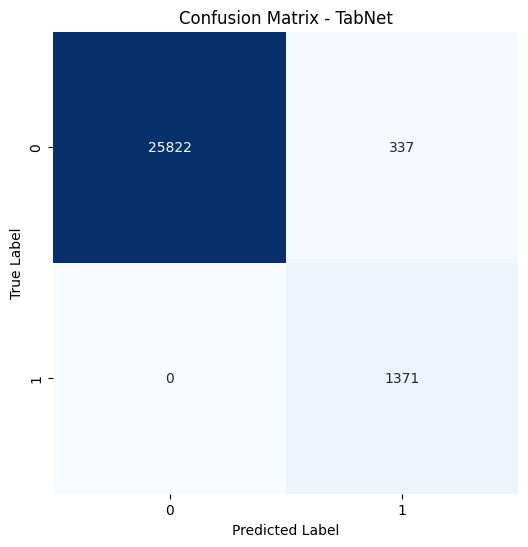

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     26159
           1       0.80      1.00      0.89      1371

    accuracy                           0.99     27530
   macro avg       0.90      0.99      0.94     27530
weighted avg       0.99      0.99      0.99     27530


Evaluating CatBoost...
Accuracy:  0.9991
Precision: 0.9870
Recall:    0.9956
F1 Score:  0.9913
ROC-AUC:   1.0000


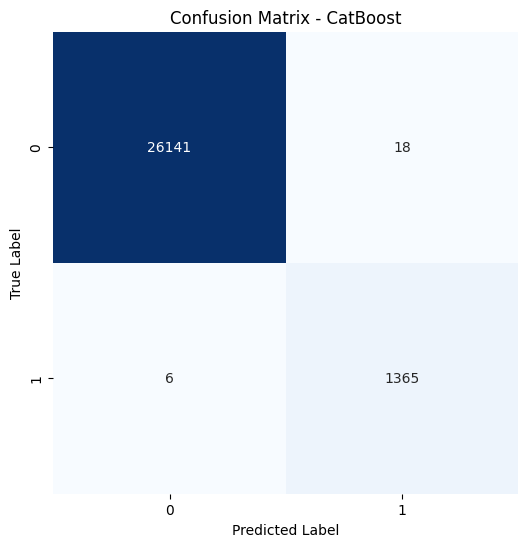

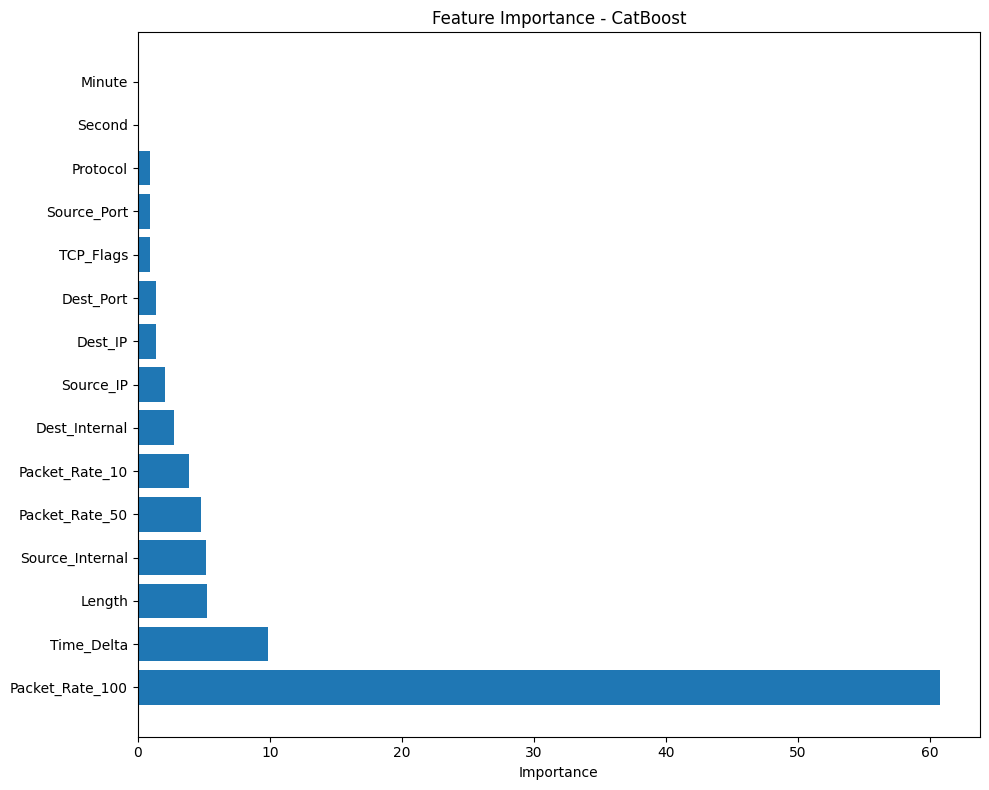

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26159
           1       0.99      1.00      0.99      1371

    accuracy                           1.00     27530
   macro avg       0.99      1.00      1.00     27530
weighted avg       1.00      1.00      1.00     27530


Evaluating LightGBM...
Accuracy:  0.9992
Precision: 0.9934
Recall:    0.9912
F1 Score:  0.9923
ROC-AUC:   1.0000


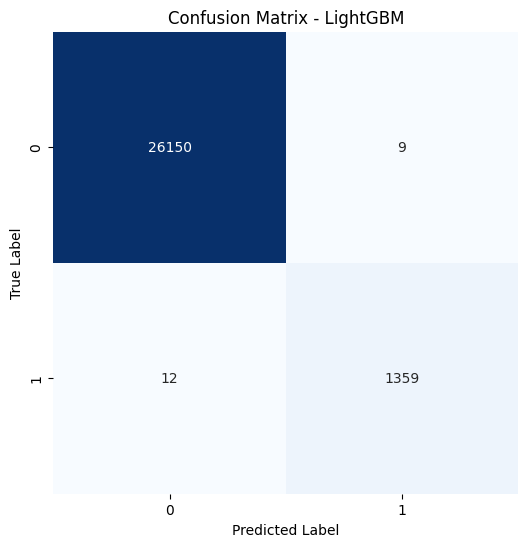

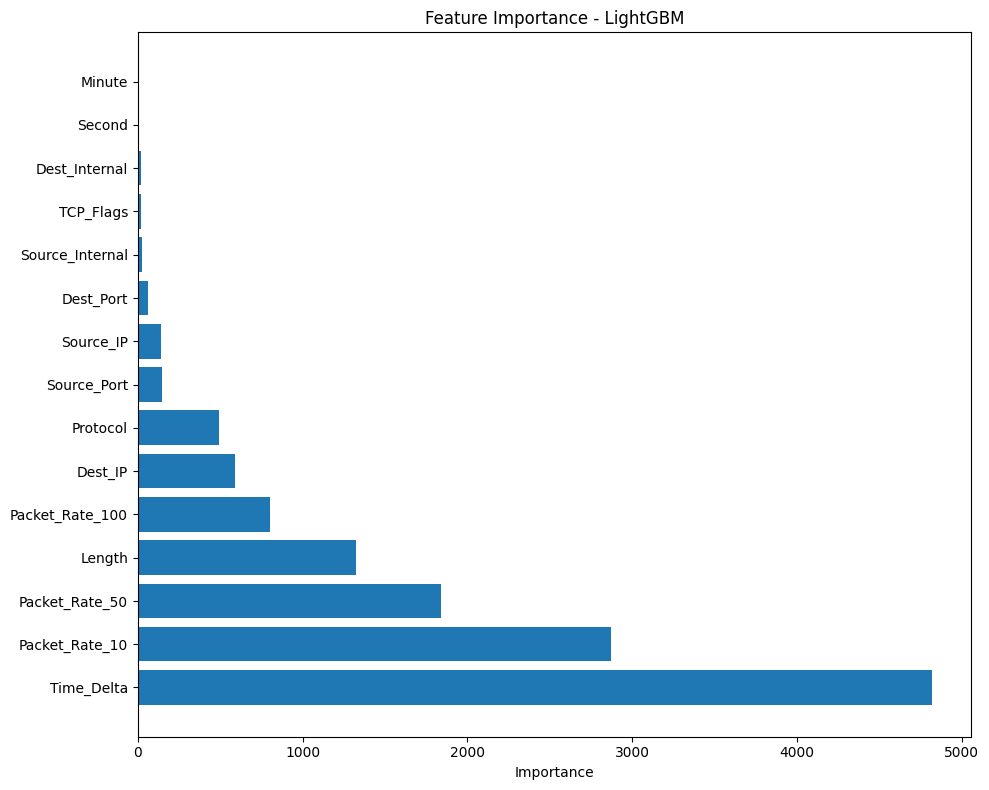

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26159
           1       0.99      0.99      0.99      1371

    accuracy                           1.00     27530
   macro avg       1.00      1.00      1.00     27530
weighted avg       1.00      1.00      1.00     27530


Evaluating XGBoost...
Accuracy:  0.9991
Precision: 0.9912
Recall:    0.9898
F1 Score:  0.9905
ROC-AUC:   1.0000


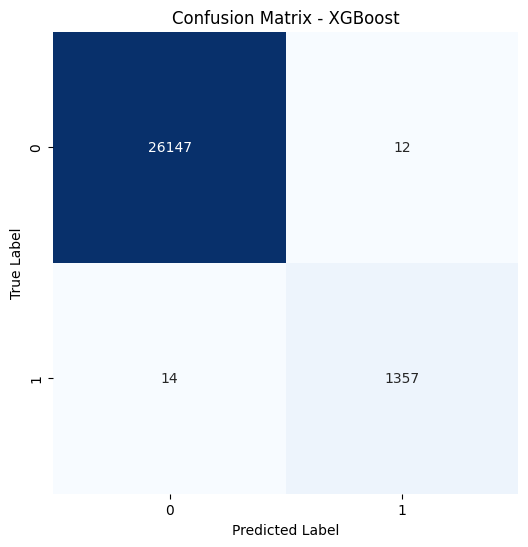

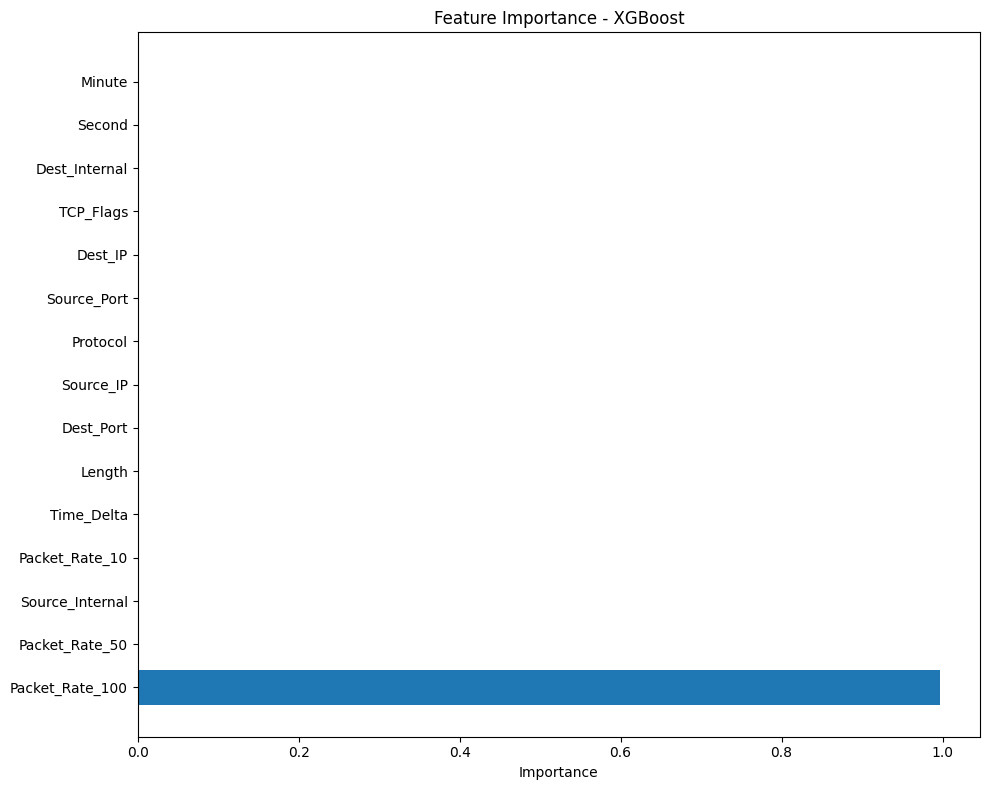

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26159
           1       0.99      0.99      0.99      1371

    accuracy                           1.00     27530
   macro avg       1.00      0.99      1.00     27530
weighted avg       1.00      1.00      1.00     27530


Evaluating StackingEnsemble...
Accuracy:  0.9991
Precision: 0.9863
Recall:    0.9949
F1 Score:  0.9906
ROC-AUC:   1.0000


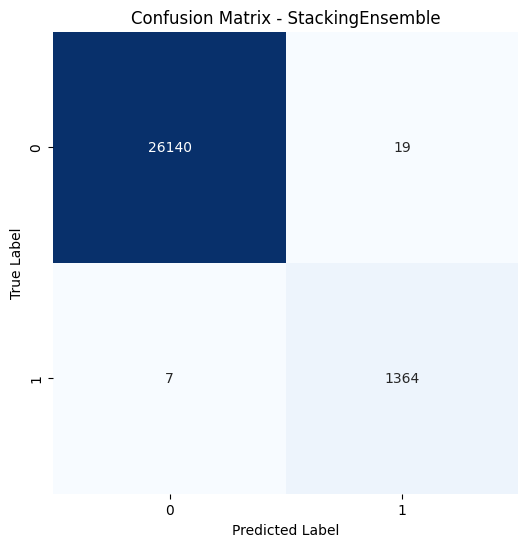

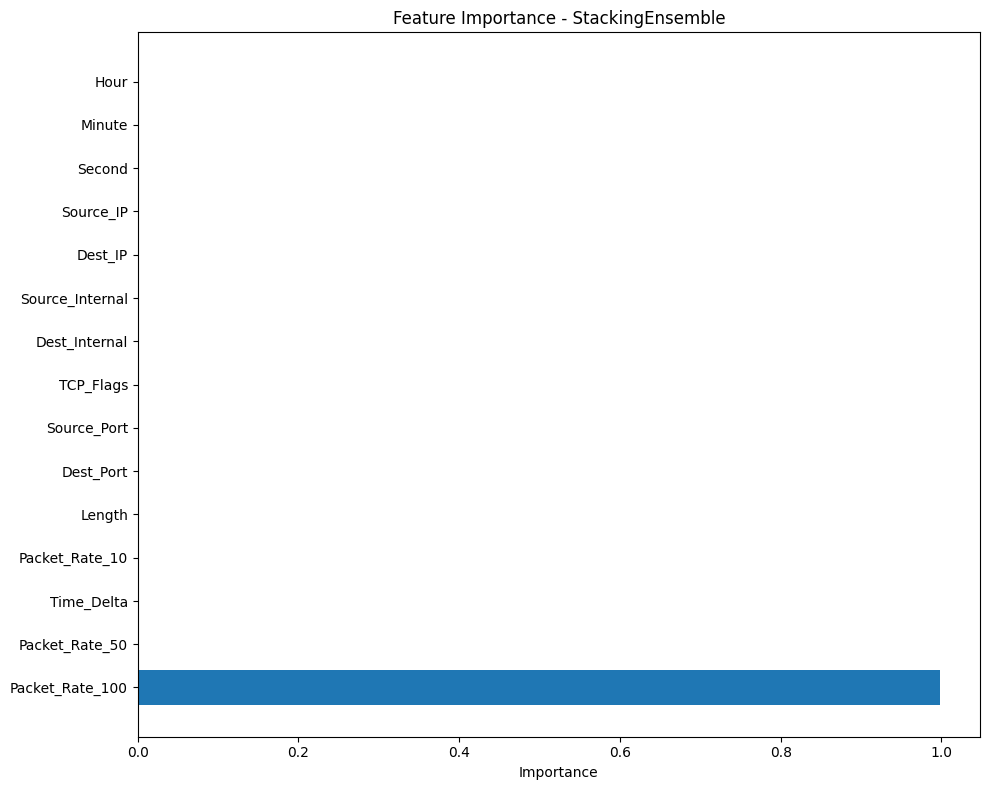

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26159
           1       0.99      0.99      0.99      1371

    accuracy                           1.00     27530
   macro avg       0.99      1.00      1.00     27530
weighted avg       1.00      1.00      1.00     27530

Creating combined model performance visualization...


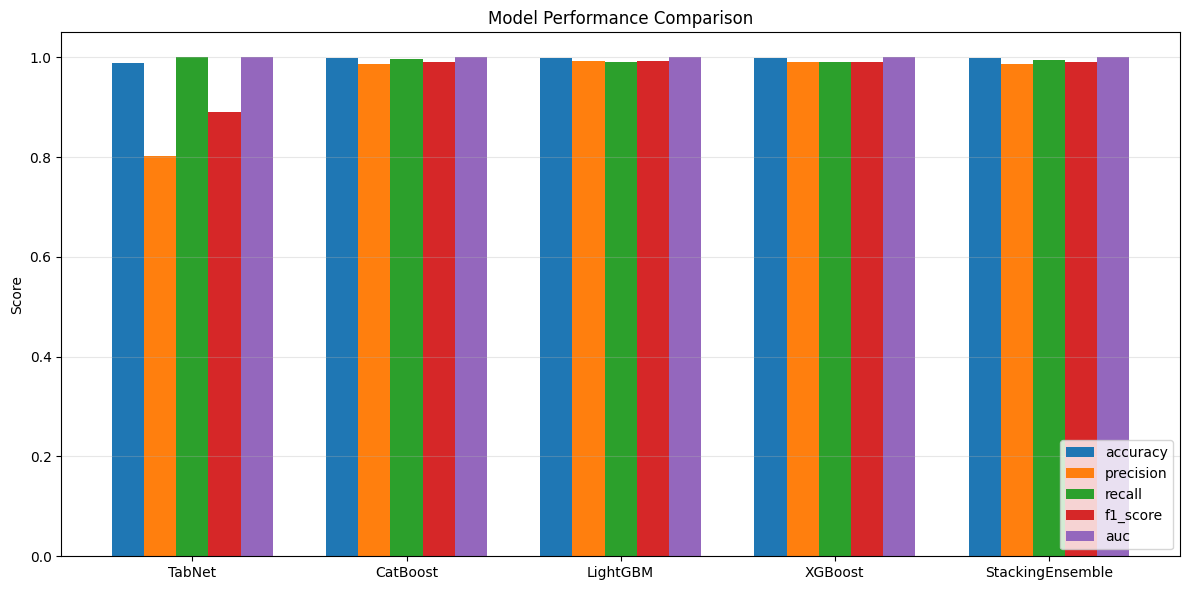


Combined Model Performance Summary:
                  accuracy  precision    recall  f1_score       auc
model_name                                                         
TabNet            0.987759   0.802693  1.000000  0.890549  0.999726
CatBoost          0.999128   0.986985  0.995624  0.991285  0.999988
LightGBM          0.999237   0.993421  0.991247  0.992333  0.999989
XGBoost           0.999056   0.991234  0.989788  0.990511  0.999986
StackingEnsemble  0.999056   0.986262  0.994894  0.990559  0.999991

Available models for visualization:
- TabNet
- CatBoost
- LightGBM
- XGBoost
- StackingEnsemble
Enter the model name you want to visualize (or type 'all' for all models): all


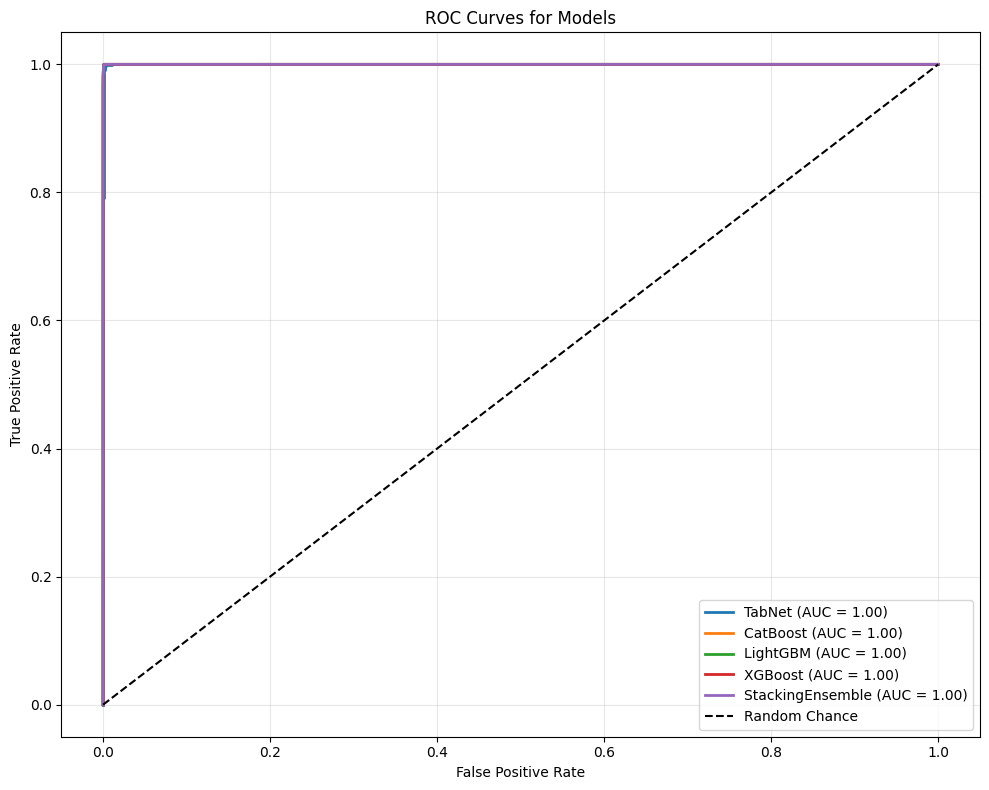

ROC curves saved to results/roc_curves.png


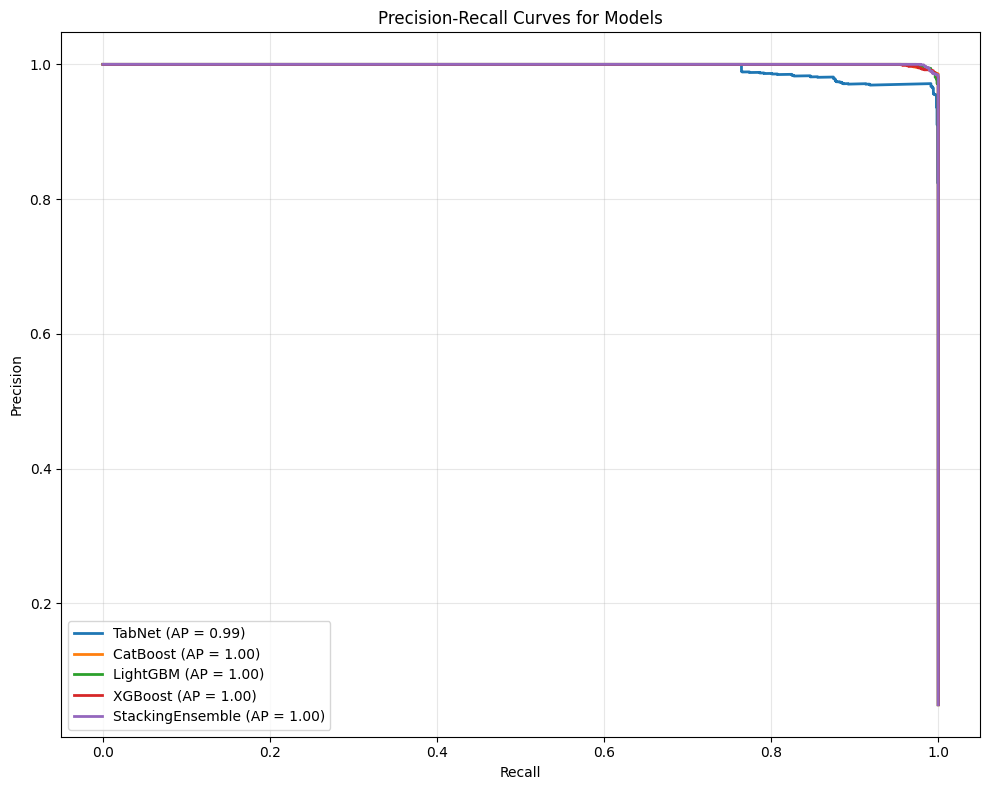

Precision-Recall curves saved to results/precision_recall_curves.png

Best performing model based on F1 score: LightGBM

Simulating real-time detection using uploaded CSV data...

Real-time Detection Results:
        Prediction    Confidence  Protocol  Length  Source_Port  Dest_Port
73782            0  2.105735e-08        14      54        62042         80
35032            0  6.769187e-08        11    1292            0          0
93414            0  1.539608e-07        11      68            0          0
52636            0  2.290123e-09        14    1466           80      62042
138382           0  2.086666e-08        17      65          443      54890
113380           0  6.741696e-08        17     454        58001        443
160208           0  7.731230e-10        17    1292        62711        443
141097           1  9.999983e-01        14      60          443      61709
49669            0  1.276250e-08        17      68          443      58001
165860           0  1.219968e-09        1

In [8]:
# -------------------------------
# Main Pipeline
# -------------------------------
def main():
    print("======= Network Intrusion Detection System Prototype =======")
    print("This notebook implements a complete NIDS using advanced ensemble models")
    print("===========================================================")

    use_real_data = input("Do you want to upload real Wireshark data? (yes/no): ").lower() == 'yes'

    if use_real_data:
        file_path = upload_wireshark_data()
        if file_path:
            raw_features = process_wireshark_data(file_path)
            if raw_features is None:
                print("Error processing the CSV file. Exiting.")
                return
        else:
            print("No file uploaded. Exiting.")
            return
    else:
        print("Real Wireshark data is required. Exiting.")
        return

    # Store the raw (unscaled) features for real-time detection
    detection_data = raw_features.copy()

    # Preprocess the data for modeling (this scales the features)
    X, y, feature_names, scaler = preprocess_data(raw_features.copy())
    if X is None:
        print("Error in data preprocessing. Exiting.")
        return

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    print("\nWhich models would you like to train? (Choose all that apply)")
    print("1. TabNet")
    print("2. CatBoost")
    print("3. LightGBM")
    print("4. XGBoost")
    print("5. Stacking Ensemble")
    print("6. All models")

    choice = input("Enter your choice (e.g., 1,2,3 or 6 for all): ")
    models_to_train = []
    if '6' in choice or 'all' in choice.lower():
        models_to_train = ['TabNet', 'CatBoost', 'LightGBM', 'XGBoost', 'StackingEnsemble']
    else:
        if '1' in choice:
            models_to_train.append('TabNet')
        if '2' in choice:
            models_to_train.append('CatBoost')
        if '3' in choice:
            models_to_train.append('LightGBM')
        if '4' in choice:
            models_to_train.append('XGBoost')
        if '5' in choice:
            models_to_train.append('StackingEnsemble')
    if not models_to_train:
        print("No models selected. Training all models by default.")
        models_to_train = ['TabNet', 'CatBoost', 'LightGBM', 'XGBoost', 'StackingEnsemble']

    print(f"Training the following models: {', '.join(models_to_train)}")
    trained_models = {}
    for model_name in models_to_train:
        try:
            if model_name == 'TabNet':
                model = train_tabnet(X_train, y_train, X_val, y_val)
            elif model_name == 'CatBoost':
                model = train_catboost(X_train, y_train)
            elif model_name == 'LightGBM':
                model = train_lightgbm(X_train, y_train)
            elif model_name == 'XGBoost':
                model = train_xgboost(X_train, y_train)
            elif model_name == 'StackingEnsemble':
                model = train_stacking_ensemble(X_train, y_train)
            trained_models[model_name] = model
            save_model(model, model_name)
            print(f"{model_name} model trained and saved successfully.")
        except Exception as e:
            print(f"Error training {model_name}: {e}")
            import traceback
            traceback.print_exc()

    all_results = []
    for model_name, model in trained_models.items():
        try:
            results = evaluate_model(model, X_test, y_test, model_name, feature_names)
            all_results.append(results)
        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")

    if all_results:
        summary_df = visualize_results(all_results)

        # List available models for visualization
        print("\nAvailable models for visualization:")
        for model_name in trained_models.keys():
            print(f"- {model_name}")

        # Prompt the user to select a model for visualization or choose 'all'
        selected_model = input("Enter the model name you want to visualize (or type 'all' for all models): ").strip()
        if selected_model.lower() == 'all':
            models_for_viz = trained_models
        elif selected_model in trained_models:
            models_for_viz = {selected_model: trained_models[selected_model]}
        else:
            print("Invalid model selection. Visualizing all models by default.")
            models_for_viz = trained_models

        # Call the additional visualization functions with the selected model(s)
        visualize_roc_curves(models_for_viz, X_test, y_test)
        visualize_precision_recall_curves(models_for_viz, X_test, y_test)

        best_model_name = summary_df['f1_score'].idxmax()
        print(f"\nBest performing model based on F1 score: {best_model_name}")
        best_model = trained_models[best_model_name]
        # Use the uploaded CSV data (raw features) for real-time detection simulation
        real_time_detection(best_model, scaler, feature_names, detection_data)
    else:
        print("No models were successfully evaluated.")

    print("\n======= Network Intrusion Detection System Prototype Complete =======")
    print("You can now use this system to detect network intrusions in real-time.")
    print("================================================================")


if __name__ == "__main__":
    main()